In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display as widgvis


def load_mnist_data() -> tuple:
    """
    Load the MNIST dataset from the keras library.
    """
    X = np.load('/content/images.npy')
    X = X.reshape(70000, 784)
    y = np.load('/content/labels.npy')

    return X, y

def normalize(X:list, Y:list) -> tuple:
    """
    Normalize the dataset by dividing each pixel value by 255.
    """
    X = X/255
    Y = Y/255

    X = X - 0.5
    Y = Y - 0.5

    X = X * 2
    Y = Y * 2

    return X, Y

def test_train_split(X:list, Y:list, splitting_ratio:float) -> tuple:
    """
    Split the dataset into training and testing sets.
    """
    X_train = X[:int(len(X)*splitting_ratio)]
    X_test = X[int(len(X)*splitting_ratio):]
    y_train = Y[:int(len(Y)*splitting_ratio)]
    y_test = Y[int(len(Y)*splitting_ratio):]
    return X_train, y_train, X_test, y_test

def displayImage(image:list):
    """
    Display an MNIST image.

    Parameters:
    -----------
    image : ndarray
        Flattened image with shape (784,)
    """
    # Reshape from (784,) to (28,28)
    img = image.reshape(28, 28)

    # Create a new figure with specific size
    plt.figure(figsize=(0.5, 0.5))

    # Display the image with grayscale colormap (similar to what's in your notebook)
    plt.imshow(img, cmap='gray')

    # Remove axes for cleaner display
    plt.axis('off')

    # Show the plot
    plt.show()

def displayImages(images, labels, grid_size):
    """
    Display multiple MNIST images in a square grid with labels below each image.
    """
    plt.figure(figsize=(grid_size, grid_size))

    for i in range(grid_size**2):
        # Create a subplot at the i-th position
        plt.subplot(grid_size, grid_size, i+1)


        random_index = np.random.randint(0, images.shape[0])
        img = images[random_index].reshape(28, 28)

        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f"Label: {labels[random_index]}")

    plt.tight_layout()
    plt.show()

def displayPredictions(images:list, labels:list, predictions:list, grid_size:int):
    """
    Display multiple MNIST images in a square grid with labels as well as predictions below each image.
    """
    plt.figure(figsize=(grid_size, grid_size))
    for i in range(grid_size**2):
        plt.subplot(grid_size, grid_size, i+1)
        random_index = np.random.randint(0, images.shape[0])
        img = images[random_index].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(f'{predictions[random_index]} | {labels[random_index]}')
    plt.tight_layout()
    plt.suptitle("Prediction | Label", fontsize=16)
    plt.subplots_adjust(top=0.9)  # Add space for the title
    plt.show()

def DisplayErrors(images:list, labels:list, predictions:list):
    """
    Display all the MNIST images that were predicted incorrectly in a grid as well as the prediction and label below each image.
    """
    incorrect_indices = np.where(predictions != labels)[0]
    grid_size = int(np.ceil(np.sqrt(len(incorrect_indices))))
    plt.figure(figsize=(grid_size, grid_size))
    for i in range(grid_size**2):
        plt.subplot(grid_size, grid_size, i+1)
        if i < len(incorrect_indices):
            img = images[incorrect_indices[i]].reshape(28, 28)
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.title(f'{predictions[incorrect_indices[i]]} | {labels[incorrect_indices[i]]}')
    plt.tight_layout()
    plt.show()
    print(f"Total errors: {len(incorrect_indices)} out of {len(images)}")


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.nn import softmax

In [4]:
X, y = load_mnist_data()
X_train, y_train, X_test, y_test = test_train_split(X, y, splitting_ratio=0.8)
X_train, X_test = normalize(X_train, X_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((56000, 784), (56000,), (14000, 784), (14000,))

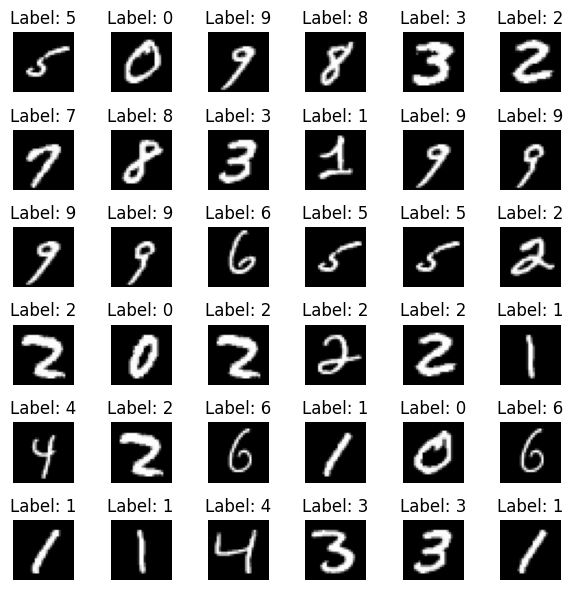

In [5]:
# random images from the dataset
displayImages(X_train[:36], y_train[:36], grid_size=6)

In [6]:
model = Sequential(
    [
        Input(shape=(784,), name='InputLayer'),

        Dense(512, activation='relu', name='L1'),
        Dropout(0.2, name='DropoutLayer1'),

        Dense(512, activation='relu', name='L2'),
        Dropout(0.2, name='DropoutLayer2'),

        Dense(10, activation='linear', name='L3'), # linear in order to benifit from logits
    ], name='softmax_10class_classifier'
)
model.summary()

Model: "softmax_10class_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ L1 (Dense)                           │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DropoutLayer1 (Dropout)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L2 (Dense)                           │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DropoutLayer2 (Dropout)              │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ L3 (Dense)                           │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 669,706 (2.55 MB)

 Trainable params: 669,706 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
[L1, _, L2, _, L3] = model.layers
W1, b1 = L1.get_weights()
W2, b2 = L2.get_weights()
W3, b3 = L3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 512), b1 shape = (512,)
W2 shape = (512, 512), b2 shape = (512,)
W3 shape = (512, 10), b3 shape = (10,)


In [8]:
model.compile(
    optimizer=Adam(1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7756 - loss: 0.7125
Epoch 2/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9351 - loss: 0.2144
Epoch 3/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9529 - loss: 0.1565
Epoch 4/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9626 - loss: 0.1221
Epoch 5/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9685 - loss: 0.1013
Epoch 6/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9727 - loss: 0.0868
Epoch 7/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9781 - loss: 0.0725
Epoch 8/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9799 - loss: 0.0648
Epoch 9/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9817 - loss: 0.0601
Epoch 10/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9836 - loss: 0.0497
Epoch 11/100
1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9832 - loss: 0.0513
Epoch 12/100
1750/1

In [10]:
print(f"W1 = {W1}, b1 = {b1}")
print(f"W2 = {W2}, b2 = {b2}")
print(f"W3 = {W3}, b3 = {b3}")

W1 = [[-0.00052534 -0.05899179 -0.01429395 ... -0.00355323  0.01285803
   0.04633099]
 [-0.01023384 -0.05166239 -0.00490163 ...  0.05130348  0.05276926
   0.03804519]
 [-0.00601978  0.00399053  0.02222868 ...  0.059145    0.01248229
  -0.02514669]
 ...
 [ 0.00406136 -0.04054191 -0.05635989 ... -0.02761112 -0.03465588
   0.06240308]
 [ 0.02332119  0.03948121 -0.03337316 ... -0.01140504 -0.0207432
   0.0401793 ]
 [ 0.01561522 -0.03349348  0.05089831 ...  0.01435616  0.00309397
   0.06239489]], b1 = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [11]:
pred = model.predict(X_test)
pred = softmax(pred)
predictions = np.zeros(pred.shape[0])

for i in range(pred.shape[0]):
    predictions[i] = np.argmax(pred[i])

predictions = predictions.astype(int)
accuracy = np.mean(predictions == y_test)
print(accuracy)

438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
0.9862142857142857


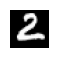

Probability Distribution : [0.0000000e+00 4.4891573e-19 1.0000000e+00 4.5394363e-21 2.5910653e-36
 7.9187089e-32 3.2415887e-30 2.1565932e-34 3.1354100e-25 0.0000000e+00]
Prediction : 2, Label : 2


In [12]:
random_index = np.random.randint(0, y_test.shape[0])
displayImage(X_test[random_index].reshape((1,784)))
print(f"Probability Distribution : {pred[random_index]}")
print(f"Prediction : {predictions[random_index]}, Label : {y_test[random_index]}")

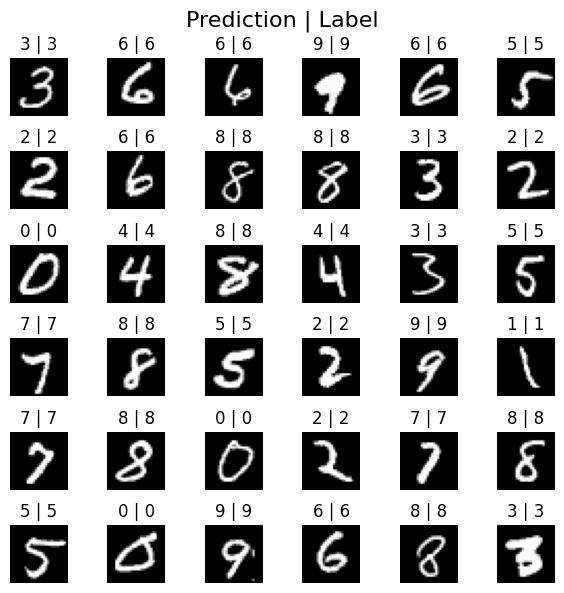

In [13]:
# display random images from the test set along with their predictions in a square grid
displayPredictions(X_test, y_test, predictions, grid_size=6)

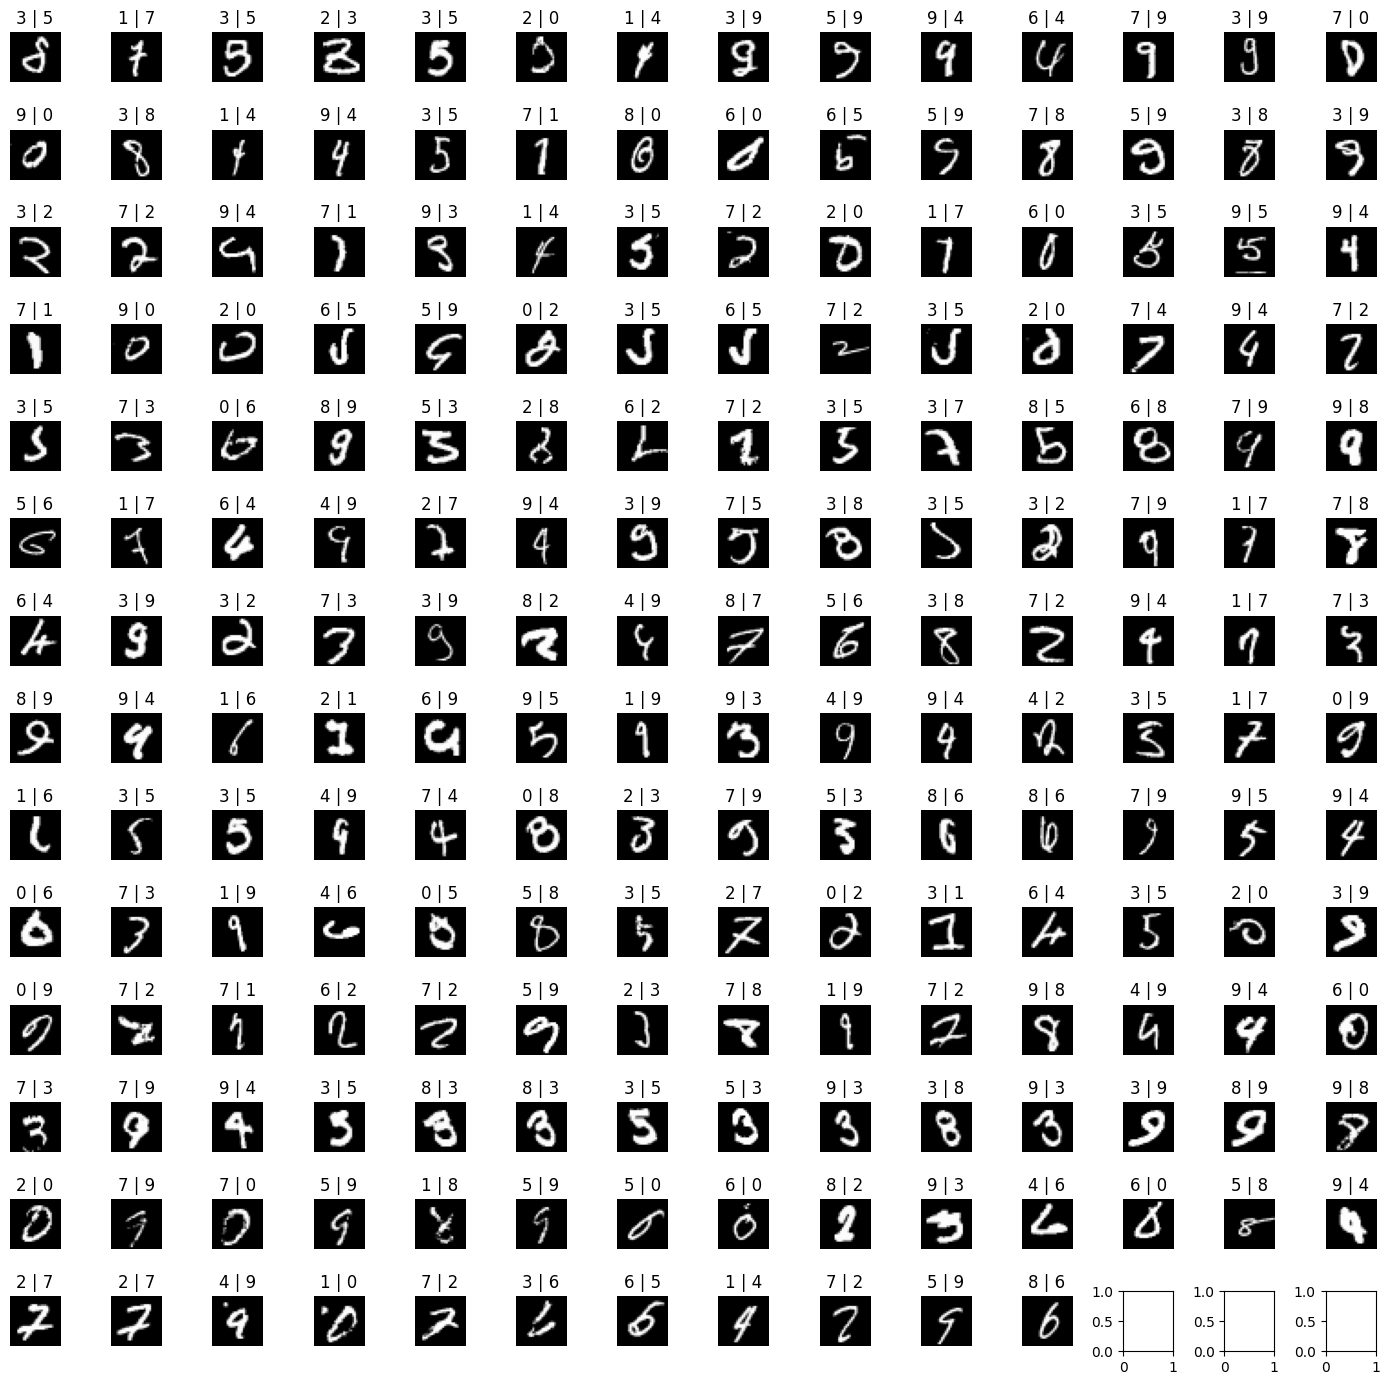

Total errors: 193 out of 14000


In [14]:
# display errors in the predictions across the test set
DisplayErrors(X_test, y_test, predictions)

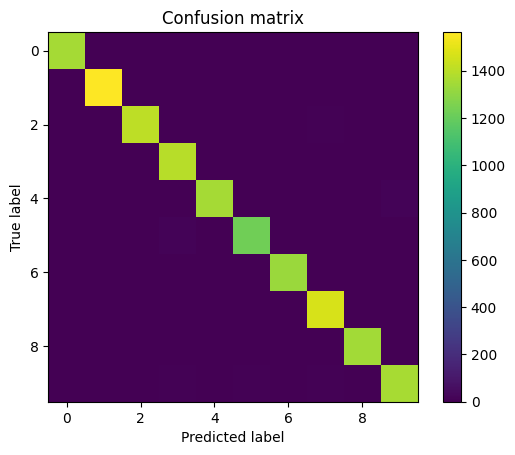

In [15]:
def DisplayConfusionMatrix(confusion_matrix: np.ndarray):
    """
    Display a confusion matrix as a heatmap.
    """
    plt.imshow(confusion_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()

# compute the confusion matrix
import tensorflow as tf
confusion_matrix = tf.math.confusion_matrix(y_test, predictions, num_classes=10)
confusion_matrix = confusion_matrix.numpy()
DisplayConfusionMatrix(confusion_matrix)

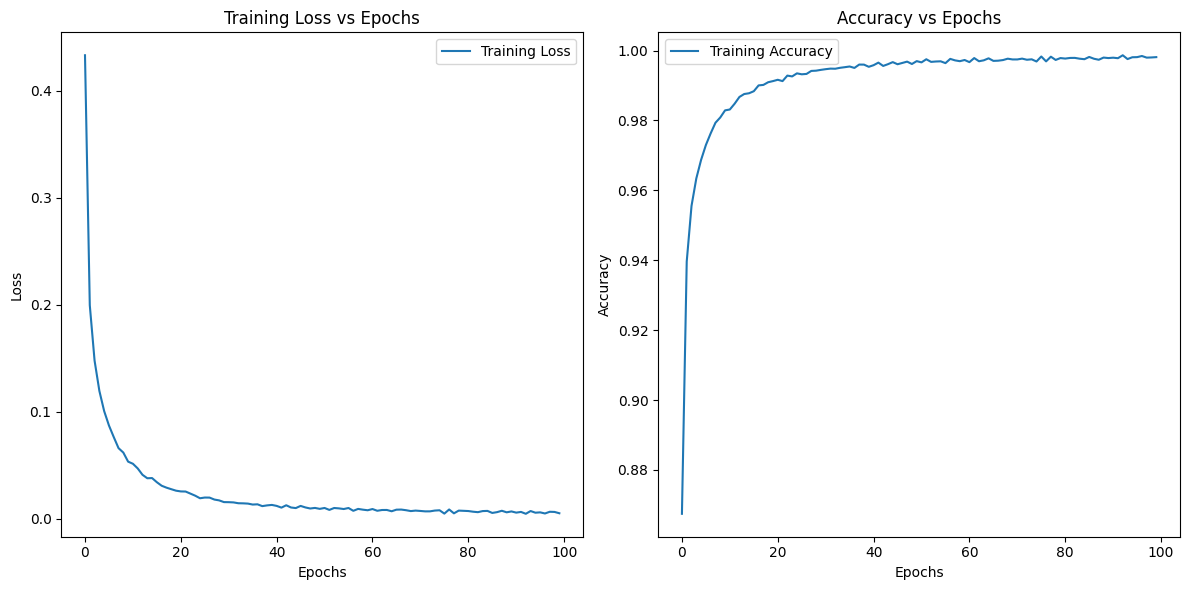

In [16]:
# cost vs epochs and accuracy vs epochs
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax[0], label='Training Loss')
sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=ax[1], label='Training Accuracy')
ax[0].set_title('Training Loss vs Epochs')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')

ax[1].set_title('Accuracy vs Epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
plt.tight_layout()
plt.show()

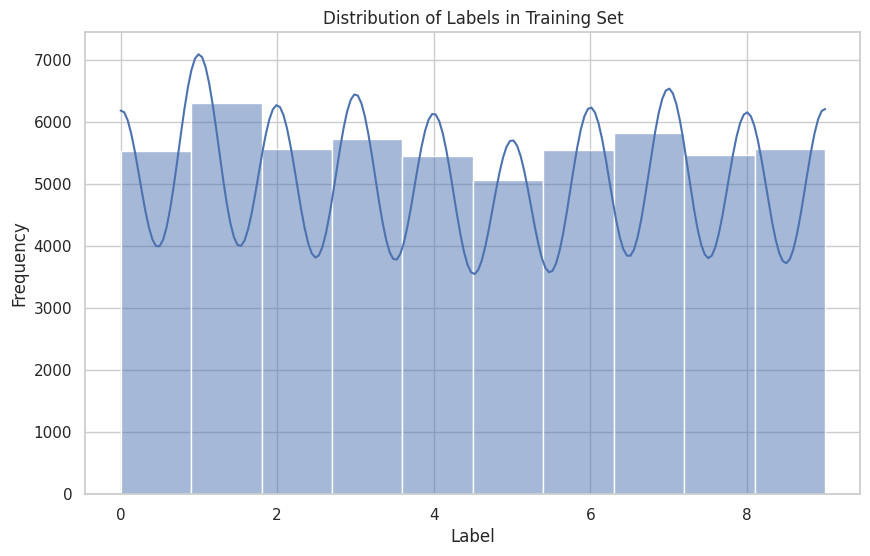

In [17]:
# distribution of each label(digit) and its KDE
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(y_train, bins=10, kde=True)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()

In [18]:
model.save('/content/savefile.keras')